
# EDA y Modelado — Víctimas por Minas Antipersonal (MAP)

Este cuaderno realiza:

- **EDA** inicial y guarda un reporte en `reports/EDA_resumen.md`
- Genera **figuras** en `figures/`
- Entrena y valida **modelos** (PM-12 / SARIMA / GBR)
- Produce **pronóstico 2024-Q1** con **IC≈95%**
- Exporta **CSVs** para el dashboard Streamlit en `outputs_parte1/`


> **Autor:** Andy Domínguez (ardominguezm@gmail.com)


In [16]:

# =============================================================
# 0) SETUP DEL REPO (clonar si hace falta y preparar carpetas)
# =============================================================
REPO_URL = "https://github.com/ardominguezm/map-parte1-streamlit.git"  # <-- CAMBIA si es distinto
REPO_DIR = "map-parte1-streamlit"

import os, pathlib
from pathlib import Path

if not Path(REPO_DIR).exists():
    !git clone $REPO_URL
%cd $REPO_DIR

# Rutas base
ROOT = Path.cwd()
DATA_DIR = ROOT / "data"
OUT_DIR  = ROOT / "outputs_parte1"
FIG_DIR  = ROOT / "figures"
RPT_DIR  = ROOT / "reports"
for p in (DATA_DIR, OUT_DIR, FIG_DIR, RPT_DIR):
    p.mkdir(parents=True, exist_ok=True)

print("Working dir:", ROOT)
print("Subdirs:", DATA_DIR, OUT_DIR, FIG_DIR, RPT_DIR, sep="\n- ")


Cloning into 'map-parte1-streamlit'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 192 (delta 28), reused 3 (delta 3), pack-reused 141 (from 1)
Receiving objects: 100% (192/192), 1.30 MiB | 4.51 MiB/s, done.
Resolving deltas: 100% (66/66), done.
/content/map-parte1-streamlit/map-parte1-streamlit
Working dir: /content/map-parte1-streamlit/map-parte1-streamlit
Subdirs:
- /content/map-parte1-streamlit/map-parte1-streamlit/data
- /content/map-parte1-streamlit/map-parte1-streamlit/outputs_parte1
- /content/map-parte1-streamlit/map-parte1-streamlit/figures
- /content/map-parte1-streamlit/map-parte1-streamlit/reports


In [26]:

# =====================================
# 1) Dependencias
# =====================================
!pip -q install plotly tqdm > /dev/null


In [18]:

# =====================================
# 2) Imports y utilidades
# =====================================
import os, re, math, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Rutas creadas en el setup
ROOT = Path.cwd()
DATA_DIR = ROOT / "data"
OUT_DIR  = ROOT / "outputs_parte1"
FIG_DIR  = ROOT / "figures"
RPT_DIR  = ROOT / "reports"

def savefig(name, tight=True):
    fname = FIG_DIR / f"{name}.png"
    if tight:
        plt.savefig(fname, dpi=200, bbox_inches="tight", facecolor="white")
    else:
        plt.savefig(fname, dpi=200, facecolor="white")
    print("✓ figura guardada:", fname)

def write_report_md(lines, name="EDA_resumen.md"):
    path = RPT_DIR / name
    path.write_text("\n".join(lines), encoding="utf-8")
    print("✓ reporte escrito:", path)

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom[denom == 0] = 1.0
    return float(np.mean(np.abs(y_true - y_pred) / denom))

def rmse_np(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))



## EDA — Carga y limpieza
Archivo CSV en `data/`:  
**`Eventos_Minas_Antipersonal_en_Colombia.csv`**.


In [27]:

# =====================================
# 3) Cargar CSV y EDA básico
# =====================================
CSV_NAME = "Eventos_Minas_Antipersonal_ en_ Colombia.csv"
DATA_PATH = DATA_DIR / CSV_NAME
assert DATA_PATH.exists(), f"No se encontró {DATA_PATH}. Subir a /data."

raw = pd.read_csv(DATA_PATH)
print("Columnas:", list(raw.columns)[:20])
display(raw.head(3))

# --- Limpieza robusta (fechas/tipos) ---
def to_year(x):
    s = re.sub(r"\D", "", str(x))
    return int(s) if s and s != "nan" else np.nan

df = raw.copy()
df["year"] = df["ano"].apply(to_year).astype("Int64")
df["month"] = pd.to_numeric(df["mes"], errors="coerce").astype("Int64")
df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1), errors="coerce")

def to_int_strict(x):
    s = re.sub(r"[^\d]", "", str(x))
    return int(s) if s else np.nan

if "codigodanemunicipio" in df.columns:
    df["codigodanemunicipio"] = df["codigodanemunicipio"].apply(to_int_strict).astype("Int64")

def fix_estado_genero(d):
    if {"Hombre","Mujer"}.issubset(set(d["estado"].dropna().unique())) and        {"Herido","Muerto"}.issubset(set(d["genero"].dropna().unique())):
        d = d.rename(columns={"estado":"genero_tmp","genero":"estado_tmp"})
        d["genero"] = d["genero_tmp"]; d["estado"] = d["estado_tmp"]
        d = d.drop(columns=["genero_tmp","estado_tmp"])
    return d

df = fix_estado_genero(df)
df = df[df["date"].notna()].sort_values("date")

# --- Resumen EDA en Markdown ---
n_rows = len(df)
date_min, date_max = df["date"].min().date(), df["date"].max().date()
missing = df.isna().mean().sort_values(ascending=False).head(10)
top_dept = df["departamento"].value_counts().head(10)

eda_lines = [
    "# EDA inicial",
    f"- Filas: **{n_rows:,}**",
    f"- Rango temporal: **{date_min} → {date_max}**",
    "## Top-10 departamentos (conteo bruto de víctimas):",
    "```",
    str(top_dept),
    "```",
    "## % de faltantes (top-10 columnas):",
    "```",
    str((missing*100).round(2).astype(str) + '%'),
    "```"
]
write_report_md(eda_lines)


Columnas: ['departamento', 'codigodanedepartamento', 'municipio', 'codigodanemunicipio', 'tipoarea', 'sitio', 'ano', 'mes', 'rangoedad', 'grupoetnico', 'condicion', 'estado', 'genero', 'latitudcabecera', 'longitudcabecera', 'tipoevento', 'Ubicación', 'Actividad']


,departamento,codigodanedepartamento,municipio,codigodanemunicipio,tipoarea,sitio,ano,mes,rangoedad,grupoetnico,condicion,estado,genero,latitudcabecera,longitudcabecera,tipoevento,Ubicación,Actividad
0,ANTIOQUIA,5,GRANADA,"5,313",Rural,Sin información,"2,006",1,Mayor de 18 años,no,Civil,Hombre,Herido,6.143703,-75.185183,Sin informacion,"(6.143703, -75.185183)","Pasando, estando cerca"
1,CAQUETA,18,MONTAÑITA,"18,410",Rural,Sin información,"2,009",12,Mayor de 18 años,no,Civil,Hombre,Herido,1.494944,-75.463090,Sin informacion,"(1.49494421255, -75.4630895064)",Erradicador manual - PCI
2,BOLIVAR,13,ARENAL,"13,042",Rural,Sin información,"2,023",2,Mayor de 18 años,no,Civil,Hombre,Herido,8.471395,-73.942728,Campo,"(8.47139540671, -73.9427278067)",Agricultura


✓ reporte escrito: /content/map-parte1-streamlit/map-parte1-streamlit/reports/EDA_resumen.md


,victims
date,
2022-11-01,10
2022-12-01,16
2023-01-01,16
2023-02-01,11
2023-03-01,9
2023-04-01,4
2023-05-01,9
2023-06-01,12
2023-07-01,3


✓ figura guardada: /content/map-parte1-streamlit/map-parte1-streamlit/figures/hist_nacional.png


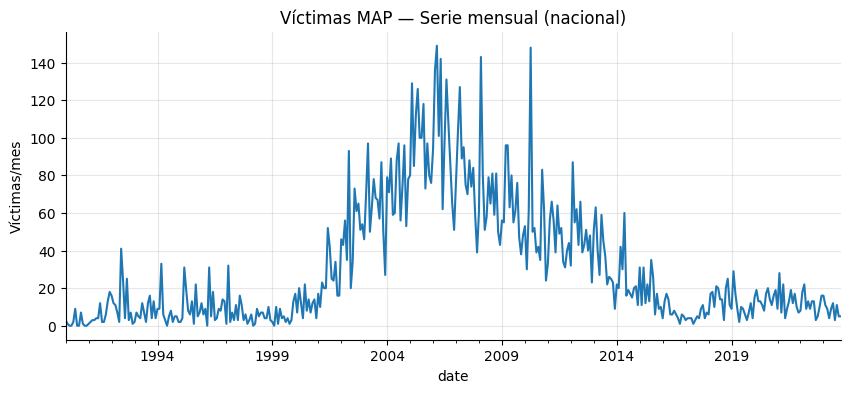

In [20]:

# =====================================
# 4) Serie mensual nacional + figura
# =====================================
monthly = df.groupby("date").size().rename("victims").sort_index()
ts = monthly.asfreq("MS").fillna(0).astype(int)

display(ts.tail(12))

fig, ax = plt.subplots()
ts.plot(ax=ax)
ax.set_title("Víctimas MAP — Serie mensual (nacional)")
ax.set_ylabel("Víctimas/mes"); ax.grid(True, alpha=0.3)
savefig("hist_nacional")
plt.show()


len(train)= 396  | len(valid)= 10
✓ figura guardada: /content/map-parte1-streamlit/map-parte1-streamlit/figures/backtest_m1.png


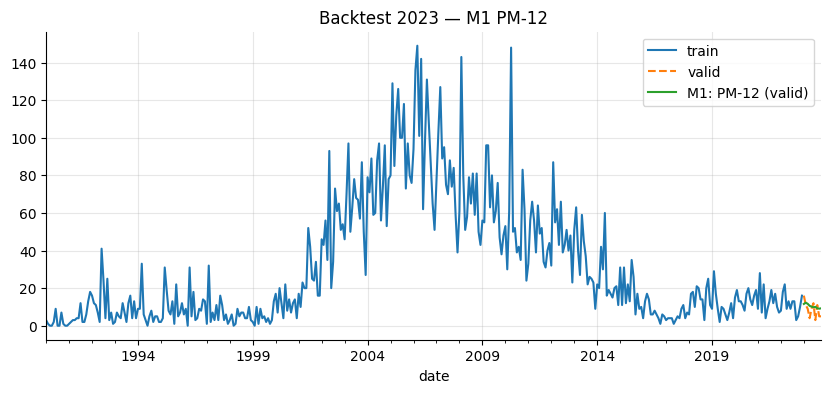

✓ figura guardada: /content/map-parte1-streamlit/map-parte1-streamlit/figures/backtest_m2.png


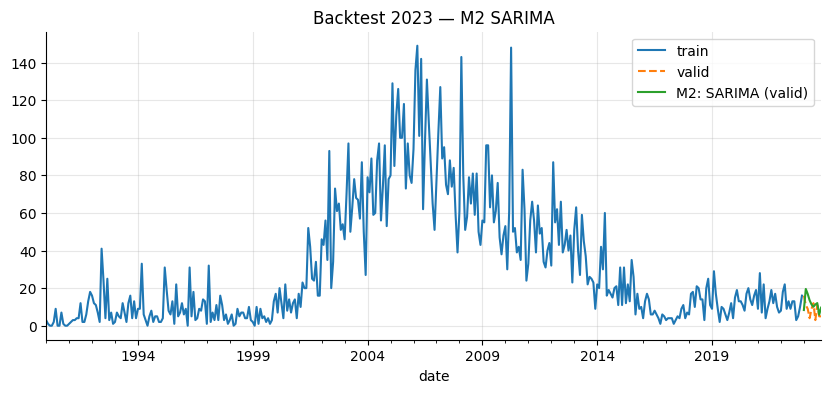

✓ figura guardada: /content/map-parte1-streamlit/map-parte1-streamlit/figures/backtest_m3.png


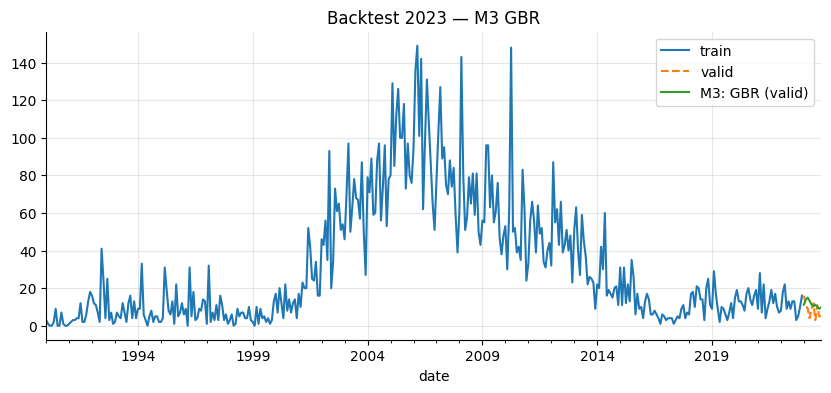

,MAE,RMSE,MAPE,sMAPE
model,,,,
M1: PM-12,3.542,4.069,0.683,0.434
M3: GBR,4.476,5.160,0.849,0.499
M2: SARIMA,5.278,6.224,0.890,0.533
Baseline Naive-12,5.400,6.633,0.844,0.532


Mejor modelo (MAE): M1: PM-12


In [21]:

# =====================================
# 5) Split + backtests (PM-12 / SARIMA / GBR)
# =====================================
train = ts.loc[:'2022-12-01']
valid = ts.loc['2023-01-01':]
print("len(train)=", len(train), " | len(valid)=", len(valid))

def eval_metrics(y_true, y_pred, name="model"):
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    mae  = float(mean_absolute_error(y_true, y_pred))
    rmse = rmse_np(y_true, y_pred)
    mape_arr = np.where(y_true == 0, np.nan, np.abs((y_true - y_pred) / y_true))
    mape = float(np.nanmean(mape_arr))
    sm   = smape(y_true, y_pred)
    return dict(model=name, MAE=mae, RMSE=rmse, MAPE=mape, sMAPE=sm)

def show_backtest(y_true, preds_dict):
    rows = [eval_metrics(y_true, yhat, name) for name, yhat in preds_dict.items()]
    rep = pd.DataFrame(rows).set_index("model").sort_values("MAE")
    display(rep.round(3))
    return rep

# PM-12
roll_preds = []
hist = ts.copy()
for t in valid.index:
    past12 = hist.loc[:t - pd.offsets.MonthBegin(1)].tail(12).mean()
    roll_preds.append(past12)
roll12_valid = pd.Series(roll_preds, index=valid.index, name="PM12")

fig, ax = plt.subplots()
train.plot(ax=ax, label="train")
valid.plot(ax=ax, label="valid", linestyle="--")
roll12_valid.plot(ax=ax, label="M1: PM-12 (valid)")
ax.set_title("Backtest 2023 — M1 PM-12")
ax.legend(); ax.grid(True, alpha=0.3)
savefig("backtest_m1")
plt.show()

# SARIMA
sar = sm.tsa.statespace.SARIMAX(train, order=(0,1,1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sar_fit = sar.fit(disp=False)
sar_valid = sar_fit.get_forecast(steps=len(valid)).predicted_mean.rename("SARIMA")

fig, ax = plt.subplots()
train.plot(ax=ax, label="train")
valid.plot(ax=ax, label="valid", linestyle="--")
sar_valid.plot(ax=ax, label="M2: SARIMA (valid)")
ax.set_title("Backtest 2023 — M2 SARIMA")
ax.legend(); ax.grid(True, alpha=0.3)
savefig("backtest_m2")
plt.show()

# GBR
Xy = pd.DataFrame({"y": ts.values}, index=ts.index)
Xy["t"] = np.arange(len(Xy))
Xy["m"] = Xy.index.month
Xy["sin12"] = np.sin(2*np.pi*Xy["m"]/12)
Xy["cos12"] = np.cos(2*np.pi*Xy["m"]/12)
for lag in [1,2,3,6,12]:
    Xy[f"lag{lag}"] = Xy["y"].shift(lag)
for w in [3,6,12]:
    Xy[f"roll{w}"] = Xy["y"].rolling(w).mean().shift(1)
Xy = Xy.dropna()

trainX = Xy.loc[:'2022-12-01']
validX = Xy.loc['2023-01-01':]
features = [c for c in Xy.columns if c != "y"]
gbr = GradientBoostingRegressor(random_state=RANDOM_STATE).fit(trainX[features], trainX["y"])
gbr_valid = pd.Series(gbr.predict(validX[features]), index=validX.index, name="GBR")

fig, ax = plt.subplots()
train.plot(ax=ax, label="train")
valid.plot(ax=ax, label="valid", linestyle="--")
gbr_valid.plot(ax=ax, label="M3: GBR (valid)")
ax.set_title("Backtest 2023 — M3 GBR")
ax.legend(); ax.grid(True, alpha=0.3)
savefig("backtest_m3")
plt.show()

# Comparativa
bench = {
    "Baseline Naive-12": ts.shift(12).loc[valid.index].rename("Naive12"),
    "M1: PM-12": roll12_valid,
    "M2: SARIMA": sar_valid,
    "M3: GBR": gbr_valid,
}
resumen = show_backtest(valid, bench)
best_model_name = resumen.index[0]
print("Mejor modelo (MAE):", best_model_name)


,forecast,lower_95,upper_95
2024-01-01,8.62,0.65,16.59
2024-02-01,8.00,0.03,15.98
2024-03-01,7.76,0.00,15.73


✓ figura guardada: /content/map-parte1-streamlit/map-parte1-streamlit/figures/hist_forecast_nacional.png


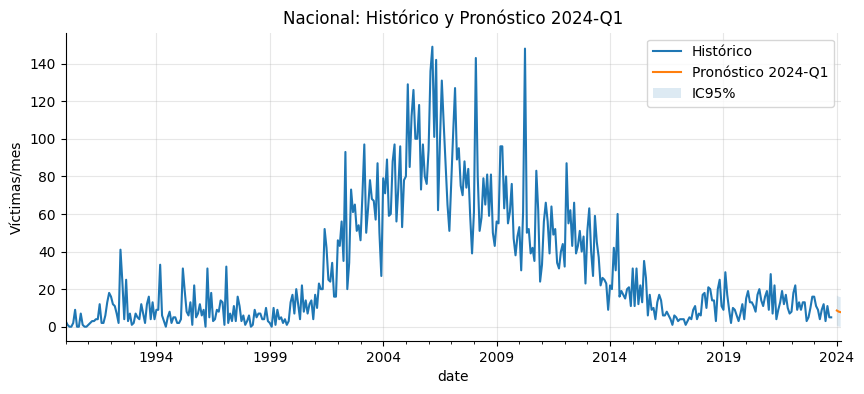

✓ figura guardada: /content/map-parte1-streamlit/map-parte1-streamlit/figures/top10_dept_q1.png


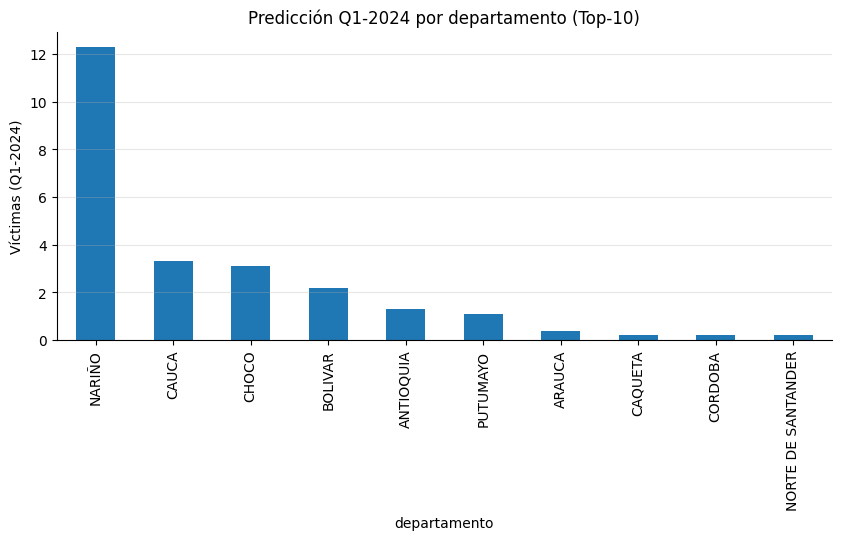

✓ Exportado CSVs a outputs_parte1/ y figuras a figures/


In [22]:

# =====================================
# 6) Pronóstico Q1-2024 + exportaciones
# =====================================
TARGET_START = pd.Timestamp("2024-01-01")
TARGET_STEPS = 3

def months_between(a, b):
    return (b.year - a.year)*12 + (b.month - a.month)

def forecast_pm12(series, steps=3):
    s = series.copy().astype(float)
    preds, idxs = [], []
    current = s.index[-1]
    for _ in range(steps):
        next_idx = current + pd.offsets.MonthBegin(1)
        yhat = float(s.tail(12).mean())
        preds.append(yhat); idxs.append(next_idx)
        s.loc[next_idx] = yhat
        current = next_idx
    return pd.Series(preds, index=pd.DatetimeIndex(idxs, freq="MS"))

def forecast_sarima(fit_model, steps=3):
    fc = fit_model.get_forecast(steps=steps).predicted_mean
    fc.index = pd.DatetimeIndex(fc.index, freq="MS")
    return fc

def _gbr_feats_for_next(s, idx):
    d = {"t":len(s), "m":idx.month}
    d["sin12"] = np.sin(2*np.pi*d["m"]/12)
    d["cos12"] = np.cos(2*np.pi*d["m"]/12)
    for lag in [1,2,3,6,12]:
        d[f"lag{lag}"] = float(s.iloc[-lag]) if len(s) >= lag else float(s.iloc[-1])
    for w in [3,6,12]:
        d[f"roll{w}"] = float(s.tail(w).mean()) if len(s) >= w else float(s.mean())
    return pd.DataFrame([d])

def forecast_gbr(series, model, steps=3):
    s = series.copy().astype(float)
    preds, idxs = [], []
    current = s.index[-1]
    for _ in range(steps):
        next_idx = current + pd.offsets.MonthBegin(1)
        Xnext = _gbr_feats_for_next(s, next_idx)
        yhat = float(model.predict(Xnext)[0])
        preds.append(yhat); idxs.append(next_idx)
        s.loc[next_idx] = yhat
        current = next_idx
    return pd.Series(preds, index=pd.DatetimeIndex(idxs, freq="MS"))

last_obs = ts.index.max()
steps_to_target_inclusive = max(1, months_between(last_obs, TARGET_START))
total_steps = steps_to_target_inclusive + (TARGET_STEPS - 1)

if best_model_name.startswith("M1"):
    fc_all = forecast_pm12(ts, steps=total_steps)
    resid = (valid - bench["M1: PM-12"]).dropna()
elif best_model_name.startswith("M2"):
    fit_full = sm.tsa.statespace.SARIMAX(
        ts, order=(0,1,1), seasonal_order=(0,1,1,12),
        enforce_stationarity=False, enforce_invertibility=False
    ).fit(disp=False)
    fc_all = forecast_sarima(fit_full, steps=total_steps)
    resid = (valid - bench["M2: SARIMA"]).dropna()
else:
    Xy_full = pd.DataFrame({"y": ts.values}, index=ts.index)
    Xy_full["t"] = np.arange(len(Xy_full))
    Xy_full["m"] = Xy_full.index.month
    Xy_full["sin12"] = np.sin(2*np.pi*Xy_full["m"]/12)
    Xy_full["cos12"] = np.cos(2*np.pi*Xy_full["m"]/12)
    for lag in [1,2,3,6,12]:
        Xy_full[f"lag{lag}"] = Xy_full["y"].shift(lag)
    for w in [3,6,12]:
        Xy_full[f"roll{w}"] = Xy_full["y"].rolling(w).mean().shift(1)
    Xy_full = Xy_full.dropna()
    gbr_full = GradientBoostingRegressor(random_state=RANDOM_STATE).fit(
        Xy_full.drop(columns=["y"]), Xy_full["y"]
    )
    fc_all = forecast_gbr(ts, gbr_full, steps=total_steps)
    resid = (valid - bench["M3: GBR"]).dropna()

fc_q1 = fc_all.loc[TARGET_START : TARGET_START + pd.DateOffset(months=TARGET_STEPS-1)]
rmse_valid = float(np.sqrt(np.mean(np.square(resid))))
ci95 = 1.96 * rmse_valid

fc_df = pd.DataFrame({
    "forecast": fc_q1.values,
    "lower_95": np.maximum(0, fc_q1.values - ci95),
    "upper_95": fc_q1.values + ci95
}, index=fc_q1.index).round(2)

display(fc_df)

# Reparto proporcional por participación reciente (12m)
end = ts.index.max()
start = end - pd.DateOffset(months=11)
mask12 = (df["date"]>=start) & (df["date"]<=end)
dept_counts = df.loc[mask12].groupby("departamento").size().sort_values(ascending=False)
dept_share  = (dept_counts / dept_counts.sum()).rename("share")
q1_total = float(fc_df["forecast"].sum())
dept_q1_pred = (dept_share * q1_total).sort_values(ascending=False).to_frame("pred_Q1_2024")

# Fig histórica + forecast + IC
hist_plus_fc = pd.concat([ts, fc_df["forecast"]])
fig, ax = plt.subplots()
ts.plot(ax=ax, label="Histórico")
fc_df["forecast"].plot(ax=ax, label="Pronóstico 2024-Q1")
if len(fc_df)>0:
    ax.fill_between(fc_df.index, fc_df["lower_95"], fc_df["upper_95"], alpha=0.15, label="IC95%")
ax.set_title("Nacional: Histórico y Pronóstico 2024-Q1")
ax.set_ylabel("Víctimas/mes"); ax.legend(); ax.grid(True, alpha=0.3)
savefig("hist_forecast_nacional")
plt.show()

# Top-10 barras
top10 = dept_q1_pred.head(10).round(1)
top10.plot(kind="bar", legend=False)
plt.title("Predicción Q1-2024 por departamento (Top-10)")
plt.ylabel("Víctimas (Q1-2024)"); plt.grid(axis="y", alpha=0.3)
savefig("top10_dept_q1")
plt.show()

# --- Exportar CSVs para el dashboard ---
ts.to_csv(OUT_DIR / "serie_nacional_mensual.csv", header=True)
fc_df.to_csv(OUT_DIR / "forecast_nacional_Q1_2024.csv", index=True)
dept_q1_pred.round(3).reset_index().rename(columns={"index":"Departamento"}).to_csv(
    OUT_DIR / "forecast_depto_Q1_2024.csv", index=False
)

# Serie departamental mensual completa
serie_dep = (
    df.groupby([pd.Grouper(key="date", freq="MS"), "departamento"])
      .size().rename("victims").reset_index()
      .rename(columns={"departamento":"Departamento"})
)
serie_dep.to_csv(OUT_DIR / "serie_departamental_mensual.csv", index=False)

print("✓ Exportado CSVs a outputs_parte1/ y figuras a figures/")


In [49]:
# ============================================================
# HeatMap interactivo por periodo con Folium (salida: HTML)
# ============================================================
import folium
from folium.plugins import HeatMap
import pandas as pd
import geopandas as gpd
from pathlib import Path

FIGDIR = Path("figures"); FIGDIR.mkdir(exist_ok=True, parents=True)
GJSON = "data/colombia_departamentos.geojson"

lat_col = "latitudcabecera"
lon_col = "longitudcabecera"

# Limpiar y asegurar fecha/coords
df_f = df.copy()
df_f["date"] = pd.to_datetime(df_f["date"], errors="coerce")
df_f = df_f[
    df_f[lat_col].between(-5.0, 13.5) &
    df_f[lon_col].between(-81.0, -66.5)
].dropna(subset=[lat_col, lon_col, "date"])

# Cargar límites para “fit_bounds” y overlay
co = gpd.read_file(GJSON).to_crs(4326)
minx, miny, maxx, maxy = co.total_bounds

periodos = [
    ("1990-1995", "1990-01-01", "1995-12-31"),
    ("1996-2000", "1996-01-01", "2000-12-31"),
    ("2001-2005", "2001-01-01", "2005-12-31"),
    ("2006-2010", "2006-01-01", "2010-12-31"),
    ("2011-2015", "2011-01-01", "2015-12-31"),
    ("2016-2020", "2016-01-01", "2020-12-31"),
    ("2021-2023", "2021-01-01", "2023-12-31")
]

def style_fn(_):
    return {"fillOpacity": 0.0, "weight": 1, "color": "#333"}  # sólo bordes

for label, start, end in periodos:
    dsub = df_f[(df_f["date"] >= start) & (df_f["date"] <= end)]
    if dsub.empty:
        print(f"⚠️  {label}: sin datos, se omite.")
        continue

    # Mapa base (centrado sobre Colombia)
    m = folium.Map(location=[4.5, -74.3], zoom_start=5, tiles="CartoDB positron")

    # Overlay de límites departamentales
    folium.GeoJson(co.__geo_interface__, style_function=style_fn, name="Departamentos").add_to(m)

    # Datos del heatmap: folium espera [lat, lon, peso]
    heat_data = dsub[[lat_col, lon_col]].values.tolist()
    HeatMap(
        heat_data,
        radius=14,      # tamaño del kernel
        blur=18,        # grado de difuminado
        min_opacity=0.2,
        max_zoom=10
    ).add_to(m)

    # Ajustar al bounding box de Colombia
    m.fit_bounds([[miny, minx], [maxy, maxx]])

    # Guardar HTML
    out = FIGDIR / f"heatmap_{label.replace('-','_')}.html"
    m.save(str(out))
    print(f"✓ Guardado {out}")

display(m)


✓ Guardado figures/heatmap_1990_1995.html
✓ Guardado figures/heatmap_1996_2000.html
✓ Guardado figures/heatmap_2001_2005.html
✓ Guardado figures/heatmap_2006_2010.html
✓ Guardado figures/heatmap_2011_2015.html
✓ Guardado figures/heatmap_2016_2020.html
✓ Guardado figures/heatmap_2021_2023.html


In [50]:
#Mapas de densidad en una unica cuadrícula
from IPython.display import display, HTML

htmls = []
for label, start, end in periodos:
    dsub = df_f[(df_f["date"] >= start) & (df_f["date"] <= end)]
    if dsub.empty:
        continue

    m = folium.Map(location=[4.5, -74.3], zoom_start=5, tiles="CartoDB positron")
    HeatMap(dsub[[lat_col, lon_col]].values.tolist(), radius=14, blur=18).add_to(m)
    m.fit_bounds([[miny, minx], [maxy, maxx]])
    htmls.append((label, m._repr_html_()))

# Mostrar en un grid (2 columnas)
grid = "<table>"
for i, (label, h) in enumerate(htmls):
    if i % 2 == 0: grid += "<tr>"
    grid += f"<td><h4>{label}</h4>{h}</td>"
    if i % 2 == 1: grid += "</tr>"
grid += "</table>"

display(HTML(grid))
